<a href="https://colab.research.google.com/github/COINS-SS21/moody-ser/blob/main/Data_loading_pp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisites

In [ ]:
import json
from functools import partial

import pandas as pd
import numpy as np
import librosa
from pathlib import Path
from tqdm.notebook import tqdm
# Register `pandas.progress_apply` and `pandas.Series.map_apply` with `tqdm`
tqdm.pandas()

from sklearn.model_selection import StratifiedShuffleSplit

import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline
ipd.set_matplotlib_formats("retina")

# Set random seed
import random 
random.seed(123)
np.random.seed(123)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
audio_df = pd.DataFrame(columns=["path", "emotion", "waveform"])
audio_df = audio_df.astype({
  "path": str,
  "emotion": int,
  "waveform": object
})

In [ ]:
# The list index corresponds to the index of the emotion
# For example: neutral=0, happy=1, sad=2, ...
EMOTIONS = [
  "neutral",
  "happy", 
  "sad",
  "angry", 
  "fearful",
  "disgusted", 
  "surprised", 
]

In [ ]:
# Convenience functions for plotting
# Adopted from: https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  num_frames = len(waveform)
  time_axis = np.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(1, 1, figsize=(16, 9))
  axes.set_xlabel("Time [seconds]")
  axes.set_ylabel("Amplitude")
  axes.plot(time_axis, waveform, linewidth=1)
  axes.grid(True)
  if xlim:
    axes.set_xlim(xlim)
  if ylim:
    axes.set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

# Data loading

## RAVDESS data loading

**Filename identifiers (source: https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio)**

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [ ]:
data_path = Path('/content/drive/MyDrive/CNN voice emotion recognition/ravdess')
actor_dirs = [dir for dir in data_path.iterdir()]
actor_dirs.sort()

# This index is used to keep track of where we are in the DataFrame during appending the data
# Do not reset it
index_counter = 0

for actor_dir in actor_dirs:
  for sound_file_path in actor_dir.glob("*.wav"):
    # Get sound file name without .wav extension
    sound_file_name = sound_file_path.with_suffix("").name
    file_name_identifiers = sound_file_name.split("-")
    audio_df.loc[index_counter] = {
        "path": str(sound_file_path),
        # Merge calm emotion with neutral emotion
        "emotion": int(file_name_identifiers[2]) - 1 if int(file_name_identifiers[2]) == 1 else int(file_name_identifiers[2]) - 2,
    }
    index_counter += 1

## SAVEE data loading
Data source: https://www.kaggle.com/barelydedicated/savee-database

In [ ]:
# The emotional intensity of this dataset is very low (british)
# The qualitiy is also not as good (there are background noises etc.)
# data_path = Path('/content/drive/MyDrive/CNN voice emotion recognition/savee')
# actor_dirs = [dir for dir in data_path.iterdir()]
# actor_dirs.sort()
# 
# emotion_identifiers = {
#     "a": 3,
#     "d": 5,
#     "f": 4,
#     "h": 1,
#     "n": 0,
#     "sa": 2,
#     "su": 6
# }
# 
# for actor_dir in actor_dirs:
#   for sound_file_path in actor_dir.glob("*.wav"):
#     # Get sound file name without .wav extension
#     sound_file_name = sound_file_path.with_suffix("").name
# 
#     emotion: int = emotion_identifiers.get(sound_file_name[0], None)
#     if emotion is None:
#       emotion = emotion_identifiers.get(sound_file_name[0:2], None)
#     if emotion is None:
#       raise Exception(f"Emotion not identified for {sound_file_path}.")
#     audio_df.loc[index_counter] = {
#         "path": str(sound_file_path),
#         "emotion": emotion,
#     }
#     index_counter += 1

## EMO-DB data loading
Data source and emotion codes: http://emodb.bilderbar.info/docu/#docu

In [ ]:
data_path = Path('/content/drive/MyDrive/CNN voice emotion recognition/emodb').glob("*.wav")

emotion_identifiers = {
    "W": 3,
    "L": 0, # boredom is very similar neutral/calm in RAVDESS
    "E": 5,
    "A": 4,
    "F": 1,
    "T": 2,
    "N": 0
    # There is no emotion for surprised in EMO-DB
}

for sound_file_path in data_path:
  # Get sound file name without .wav extension
  sound_file_name = sound_file_path.with_suffix("").name

  emotion: int = emotion_identifiers.get(sound_file_name[-2], None)
  if emotion is None:
    raise Exception(f"Emotion not identified for {sound_file_path}.")
  audio_df.loc[index_counter] = {
      "path": str(sound_file_path),
      "emotion": emotion,
  }
  index_counter += 1

## TESS data loading
Data source: https://www.kaggle.com/ejlok1/toronto-emotional-speech-set-tess

In [ ]:
data_path = Path('/content/drive/MyDrive/CNN voice emotion recognition/tess')
actor_dirs = [dir for dir in data_path.iterdir()]
actor_dirs.sort()

emotion_identifiers = {
    "fear": 4,
    "ps": 6,
    "sad": 2,
    "angry": 3,
    "disgust": 5,
    "happy": 1,
    "neutral": 0
}

for actor_dir in actor_dirs:
  for sound_file_path in actor_dir.glob("*.wav"):
    # Get sound file name without .wav extension
    sound_file_name = sound_file_path.with_suffix("").name
    file_name_identifiers: list = sound_file_name.split("_")

    emotion: int = emotion_identifiers.get(file_name_identifiers[2], None)
    if emotion is None:
      raise Exception(f"Emotion not identified for {sound_file_path}.")
    audio_df.loc[index_counter] = {
        "path": str(sound_file_path),
        "emotion": emotion,
    }
    index_counter += 1

## CREMA-D data loading
Data source: https://github.com/CheyneyComputerScience/CREMA-D

In [ ]:
# This data set has a very bad quality as it is crowdsourced
# data_path = Path('/content/drive/MyDrive/CNN voice emotion recognition/crema_d').glob("*.wav")
# 
# emotion_identifiers = {
#     "ANG": 3,
#     "DIS": 5,
#     "FEA": 4,
#     "HAP": 1,
#     "NEU": 0,
#     "SAD": 2,
#     # There is no emotion for surprised in CREMA-D
# }
# 
# for sound_file_path in data_path:
#   # Get sound file name without .wav extension
#   sound_file_name = sound_file_path.with_suffix("").name
#   file_name_identifiers: list = sound_file_name.split("_")
# 
#   emotion: int = emotion_identifiers.get(file_name_identifiers[2], None)
#   if emotion is None:
#     raise Exception(f"Emotion not identified for {sound_file_path}.")
#   audio_df.loc[index_counter] = {
#       "path": str(sound_file_path),
#       "emotion": emotion,
#   }
#   index_counter += 1

## JL-Corpus data loading
Data source: https://www.kaggle.com/tli725/jl-corpus

In [ ]:
data_path = Path('/content/drive/MyDrive/CNN voice emotion recognition/jl_corpus/Raw JL corpus (unchecked and unannotated)/JL(wav+txt)').glob("*.wav")

emotion_identifiers = {
    "happy": 1,
    "neutral": 0,
    "angry": 3,
    "anxious": 4, # Sounds like fearful in RAVDESS
    "excited": 6, # Sounds like surprised in RAVDESS
    "sad": 2,
    # There is no emotion for disgusted in JL-Corpus
}

for sound_file_path in data_path:
  # Get sound file name without .wav extension
  sound_file_name = sound_file_path.with_suffix("").name
  file_name_identifiers: list = sound_file_name.split("_")

  emotion: int = emotion_identifiers.get(file_name_identifiers[1], None)
  # We skip the secondary emotions of this dataset as they do not apply to our classes
  if emotion is None:
    continue
  audio_df.loc[index_counter] = {
      "path": str(sound_file_path),
      "emotion": emotion,
  }
  index_counter += 1

# Append waveform

## Normalize the waveform
This step is **very** important because the audio differs dramatically in loudness between the datasets. We do not want to fit this specific loudness.

We use the simple peak normalization technique which is commonly used for audio. This yields the same result as: https://librosa.org/doc/main/generated/librosa.util.normalize.html.

There are also more advanced techniques like loudness normalization.

In [ ]:
def peak_normalize(waveform: np.ndarray):
  return waveform / waveform.max()

def standardize(X: np.ndarray):
  return (X - X.mean()) / X.std()

# Source: https://pydiogment.readthedocs.io/en/latest/_modules/pydiogment/auga.html#normalize
def rms_normalize(waveform: np.ndarray, rms_level=0):
    r = 10 ** (rms_level / 10.0)
    a = np.sqrt((len(waveform) * r ** 2) / np.sum(waveform ** 2))
    return waveform * a

In [ ]:
lengths = []
total_crops = 0
total_pads = 0
def crop_or_pad_audio(filepath: str, target_sec=2.1, sample_rate=22050):
    global total_crops, total_pads

    target_len = int(target_sec * sample_rate)
    waveform, sample_rate = librosa.load(filepath, sr=sample_rate)

    waveform = rms_normalize(waveform)

    # First try to remove unnecessary silence
    waveform = librosa.effects.trim(waveform, ref=waveform.max(), top_db=40.0)[0]

    # Keep track of active audio length after trimming
    # The mean of this might be useful to determine the input size for a neural network
    lengths.append(len(waveform))

    # Crops or Pads the waveform at random offsets to the target length
    if len(waveform) > target_len:
        # Randomly chooses an offset
        max_offset = len(waveform) - target_len
        offset = np.random.randint(max_offset)
        # Crops the audio
        waveform = waveform[offset:(target_len + offset)]
        total_crops += 1
    else:
        # Randomly chooses an offset
        max_offset = target_len - len(waveform)
        offset = np.random.randint(max_offset) if max_offset > 0 else 0
        # Pads the audio with zeros
        waveform = np.pad(waveform, (offset, target_len - len(waveform) - offset), "constant")
        total_pads += 1

    return waveform.astype("float32")

In [ ]:
%%time
# audio_df = audio_df.sample(500)
audio_df["waveform"] = audio_df["path"].progress_apply(crop_or_pad_audio)
print(f"Total crops: {total_crops:d}")
print(f"Total pads: {total_pads:d}")


Total crops: 2635
Total pads: 3581
CPU times: user 7min 46s, sys: 8.62 s, total: 7min 55s
Wall time: 57min 26s


Mean duration: 2.1072


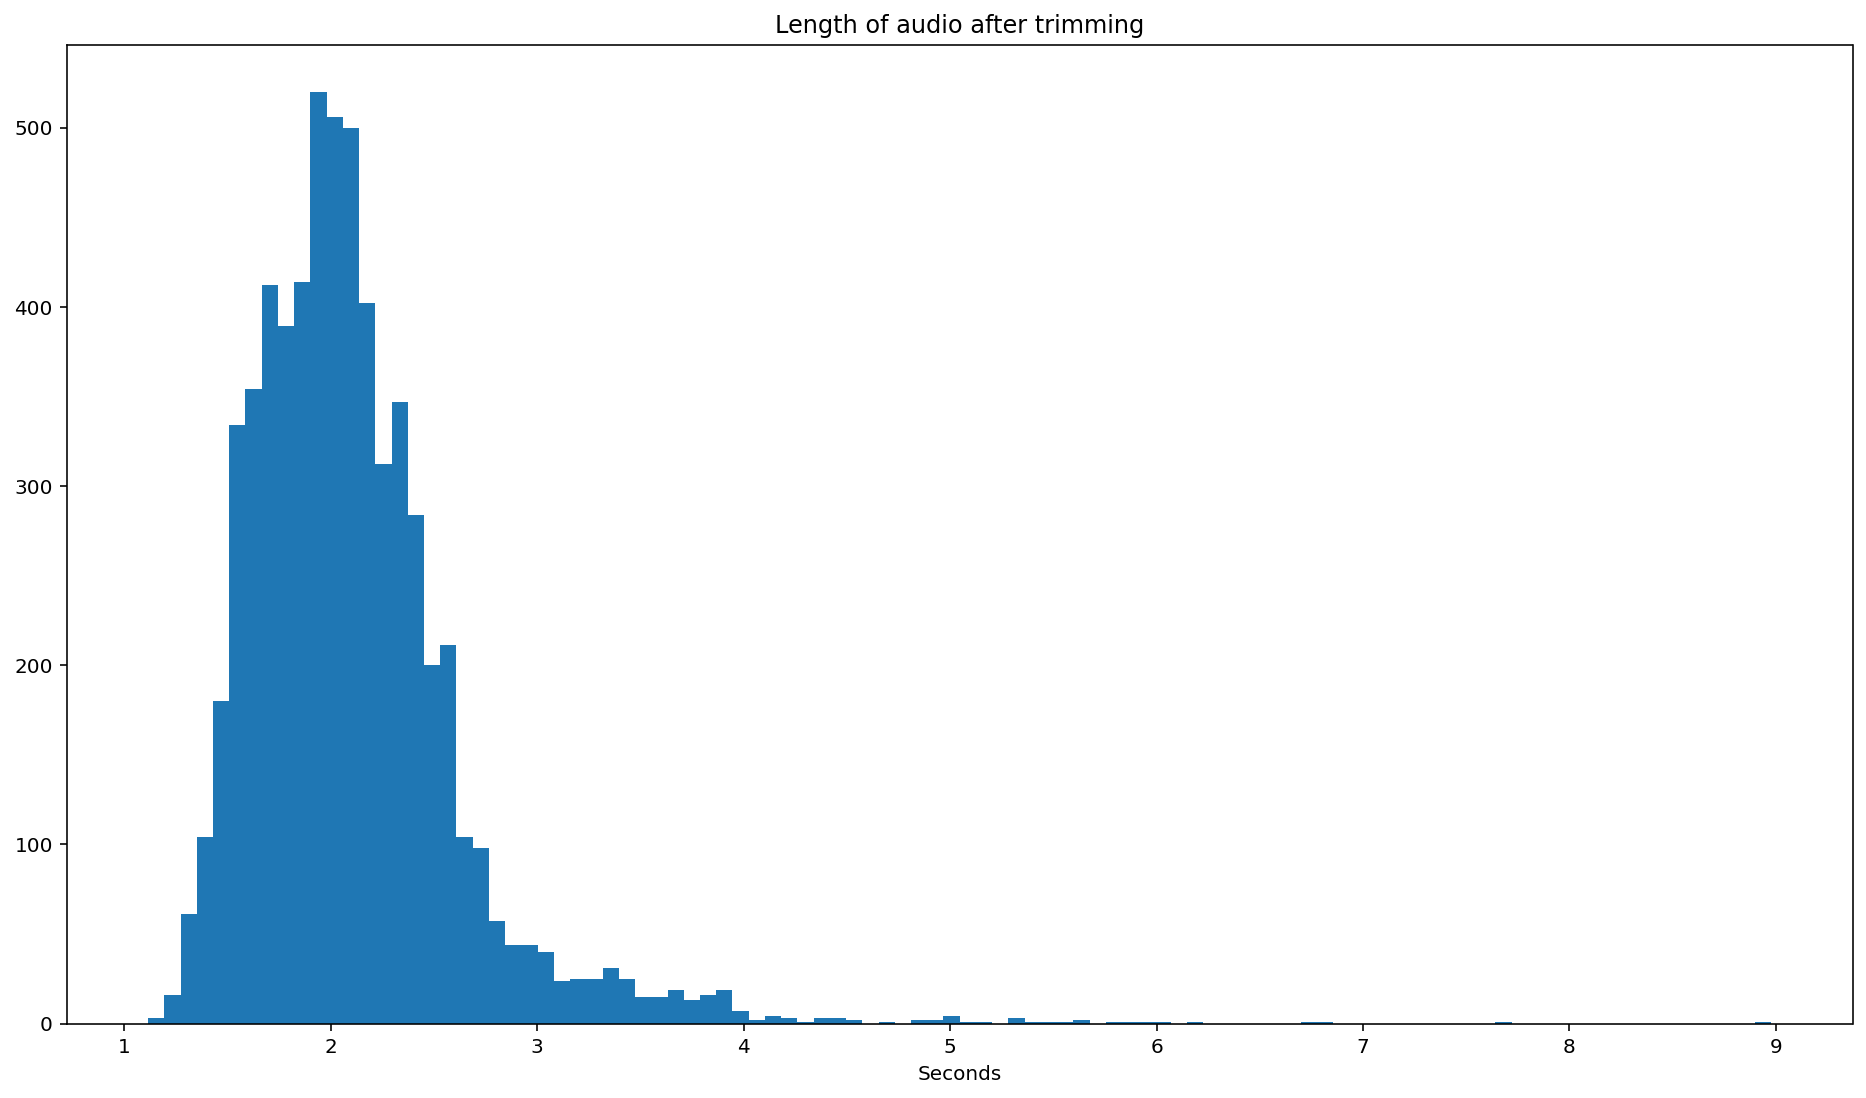

In [ ]:
print(f"Mean duration: {np.mean(np.array(lengths) / (22050)):.4f}")
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_title("Length of audio after trimming")
ax.set_xlabel("Seconds")
plt.hist(np.array(lengths) / (22050), bins=100);

# Train-Test-Split

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, train_size=0.7)
# We only do one split, therefore we can just take the first batch of the iterator returned by sss
train_idx, test_idx = next(iter(sss.split(audio_df["waveform"], audio_df["emotion"])))

In [ ]:
print("Length of training data:", len(train_idx))
print("Length of test data:", len(test_idx))

Length of training data: 4351
Length of test data: 1865


In [ ]:
train_df = audio_df.iloc[train_idx].copy()
test_df = audio_df.iloc[test_idx].copy()
del audio_df

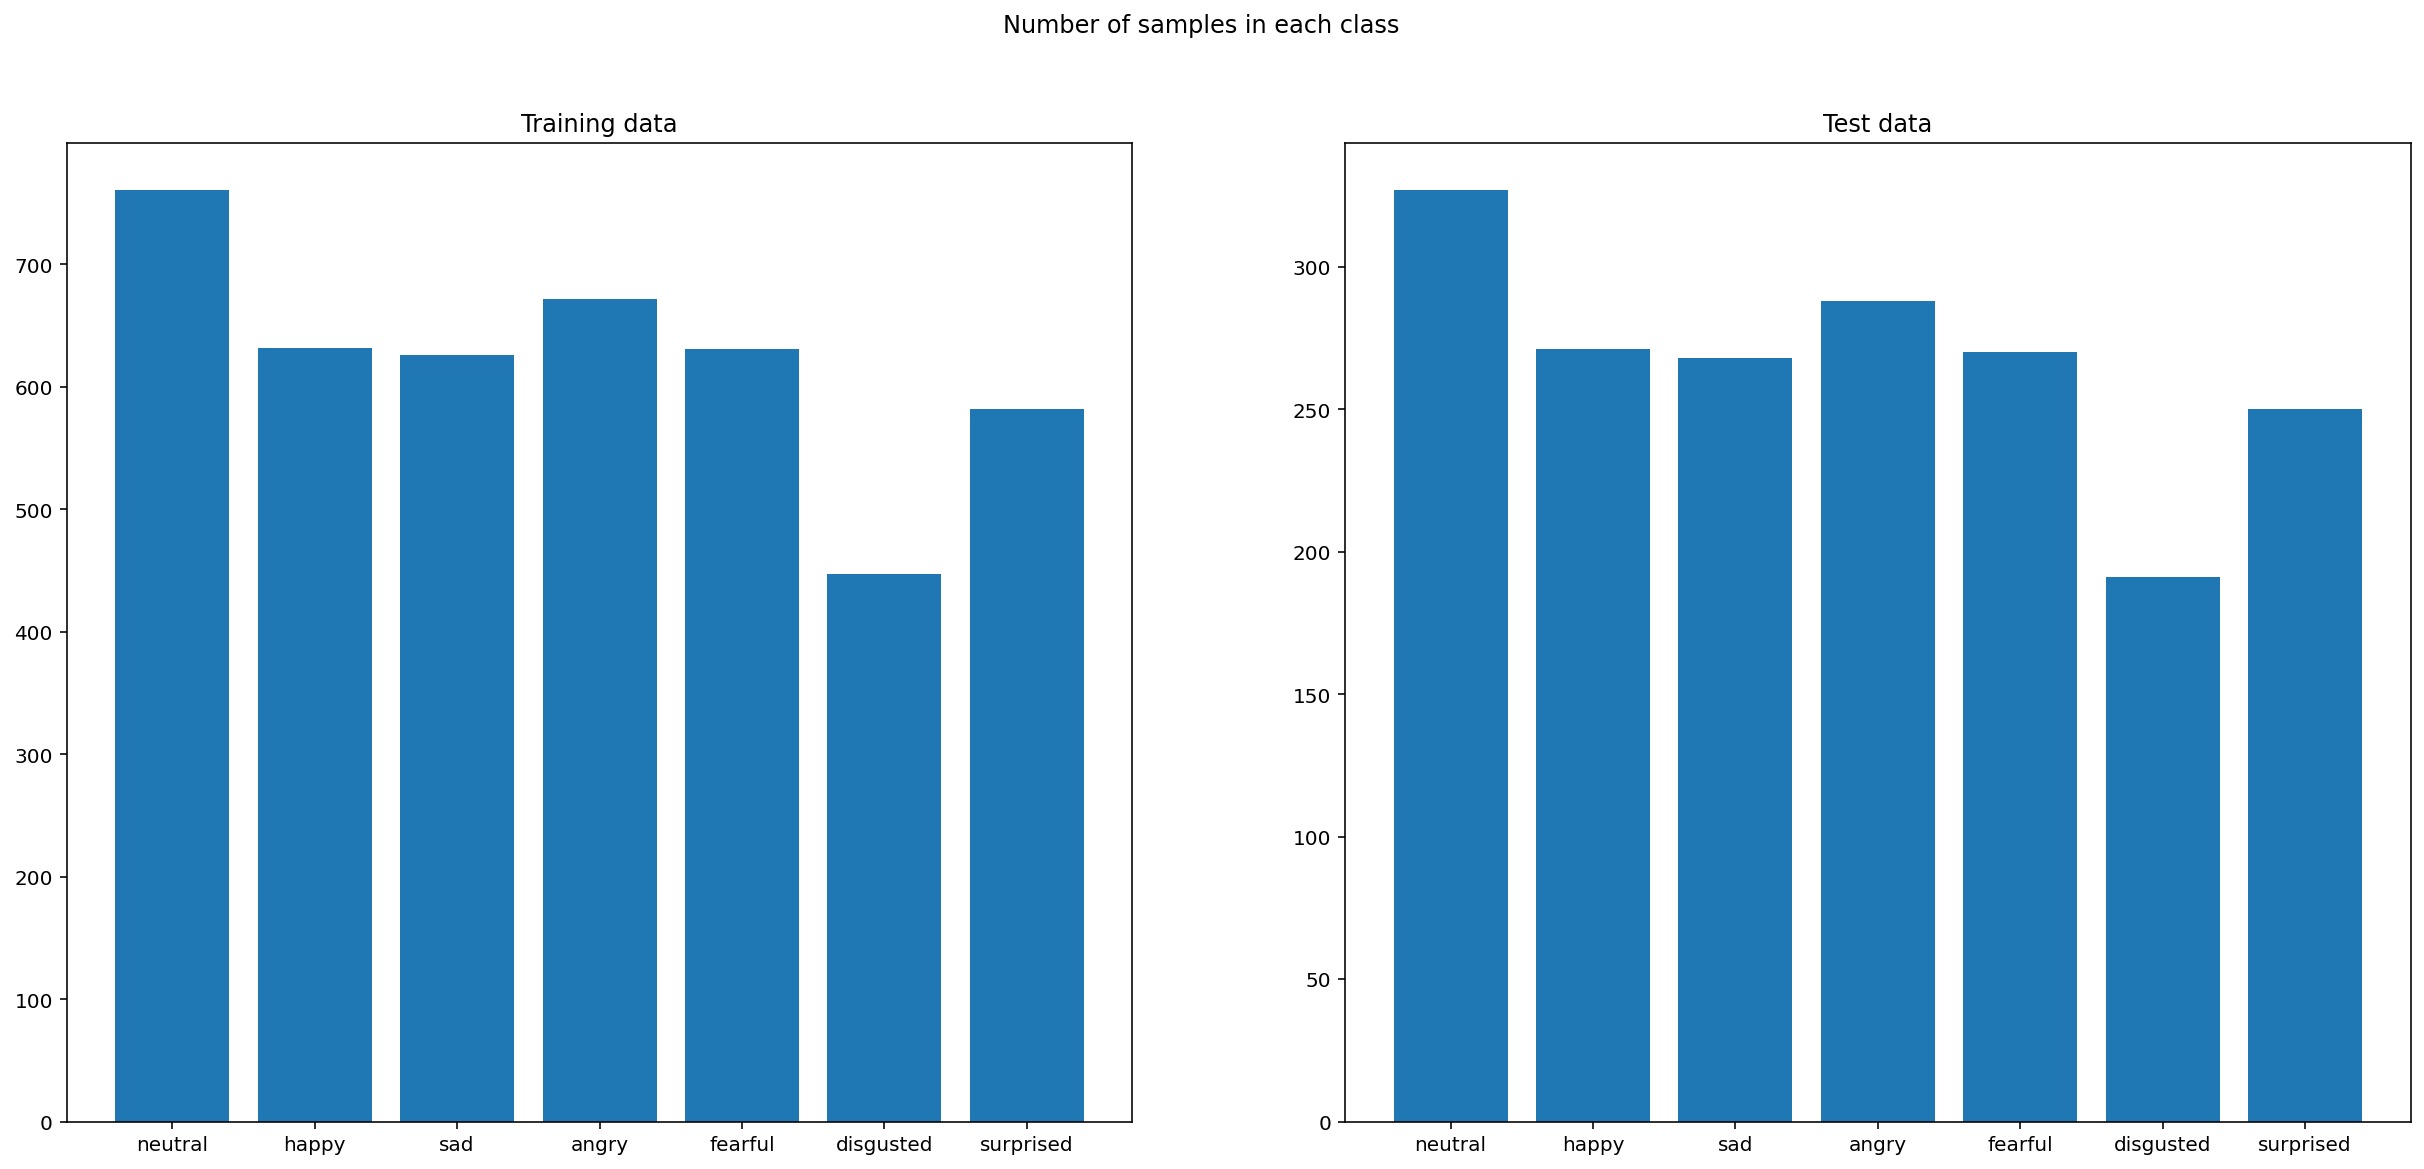

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(21, 9))
fig.suptitle("Number of samples in each class")
ax1.set_title("Training data")
ax1.bar(x=EMOTIONS, height=train_df["emotion"].value_counts().sort_index())
ax2.set_title("Test data")
ax2.bar(x=EMOTIONS, height=test_df["emotion"].value_counts().sort_index())
fig.show();

In [ ]:
train_df.to_pickle("/content/drive/MyDrive/CNN voice emotion recognition/train_df.pkl")
test_df.to_pickle("/content/drive/MyDrive/CNN voice emotion recognition/test_df.pkl")

# Data augmentation
We use seven forms of audio data augmentation defined below.

In [ ]:
def noise(data):
  # You can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
  noise_amp = 0.01 * np.random.uniform() * np.amax(data)
  data = data.astype('float32') + noise_amp * np.random.normal(size=data.shape[0])
  return data
    
def pitch(data, sample_rate):
  bins_per_octave = 12
  pitch_pm = 2
  pitch_change =  pitch_pm * 2 * np.random.uniform()
  data = librosa.effects.pitch_shift(data.astype('float32'), 
                                    sample_rate, n_steps=pitch_change, 
                                    bins_per_octave=bins_per_octave)
  # Normalize data again
  data = rms_normalize(data)
  return data

def random_shift(data):
  # Shift the data max one second to the right or left
  shift_range = int(np.random.uniform(low=-5, high=5)) * ((22050) // 5)
  return np.roll(data, shift_range)
   
def stretch(data, rate=0.8):
  original_length = len(data)
  data = librosa.effects.time_stretch(data, rate)
  # Trim the data to eventually center again
  data = librosa.effects.trim(data, ref=data.max(), top_db=40.0)[0]
  # We can only pad center if the stretched data does not exceed the original length after trimming
  if(len(data) < original_length):
    data = librosa.util.pad_center(data, original_length)
  # Normalize the sound again
  data = rms_normalize(data)
  # Return in original length again (might omit some parts when slowed down)
  return librosa.util.fix_length(data, original_length)

def left_trim(data):
  original_len = len(data)
  data = librosa.effects.trim(data, ref=data.max(), top_db=40.0)[0]
  trimmed_len = len(data)
  # We can only shift something if there is silence in the beginning or end
  if(trimmed_len < original_len):
    return librosa.util.fix_length(data, original_len)
  # Return nan if trimming was not successful
  return np.nan

def right_trim(data):
  original_len = len(data)
  data = librosa.effects.trim(data, ref=data.max(), top_db=40.0)[0]
  trimmed_len = len(data)
  # We can only shift something if there is silence in the beginning or end
  if(trimmed_len < original_len):
    # This adds zeros in the end, therefore we roll by the amount of zeros
    data = librosa.util.fix_length(data, original_len)
    return np.roll(data, original_len - trimmed_len)
  # Return nan if trimming was not successful
  return np.nan

## Visualization for one example

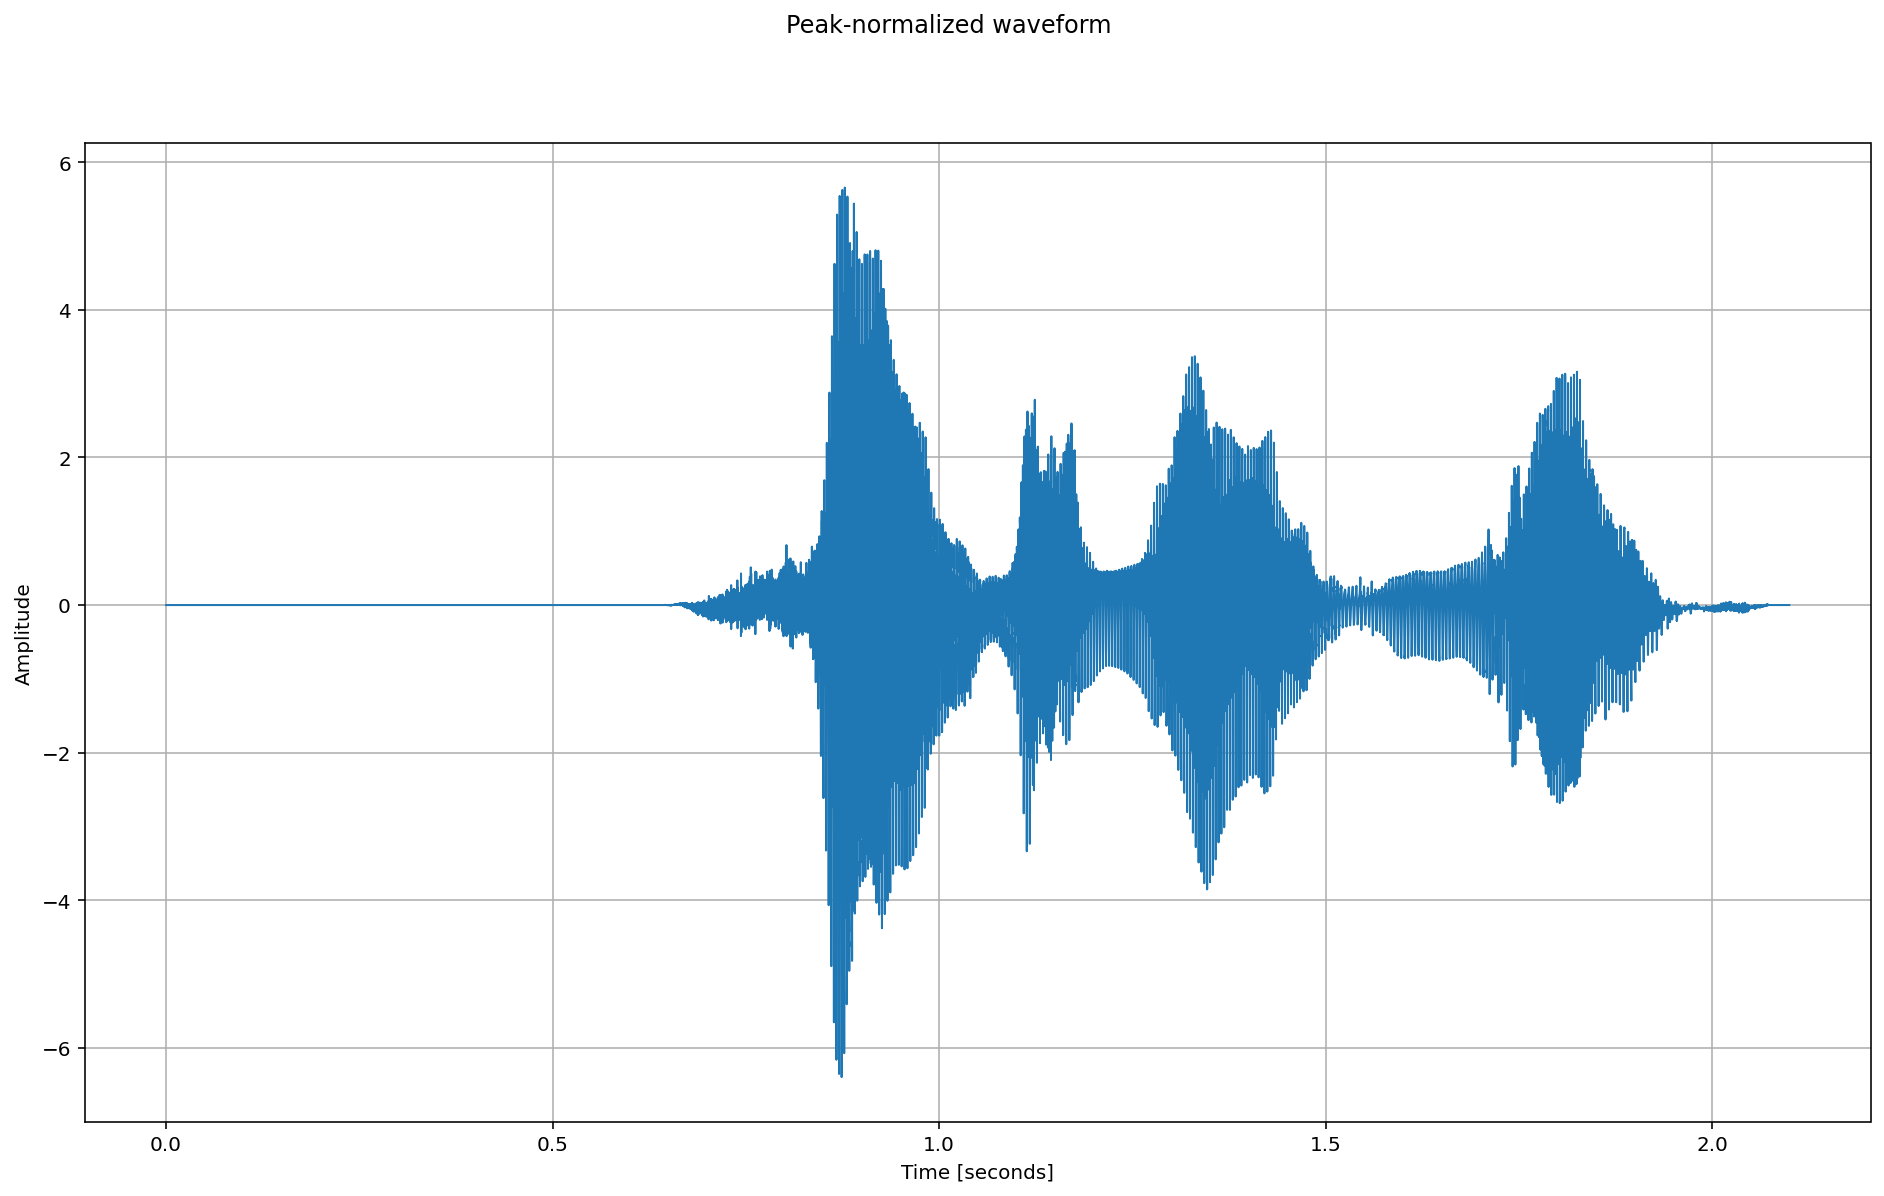

In [ ]:
sample_rate = 22050
waveform = train_df.sample().iloc[0]["waveform"]
plot_waveform(waveform, sample_rate, title="Peak-normalized waveform")
ipd.Audio(waveform, rate=sample_rate)

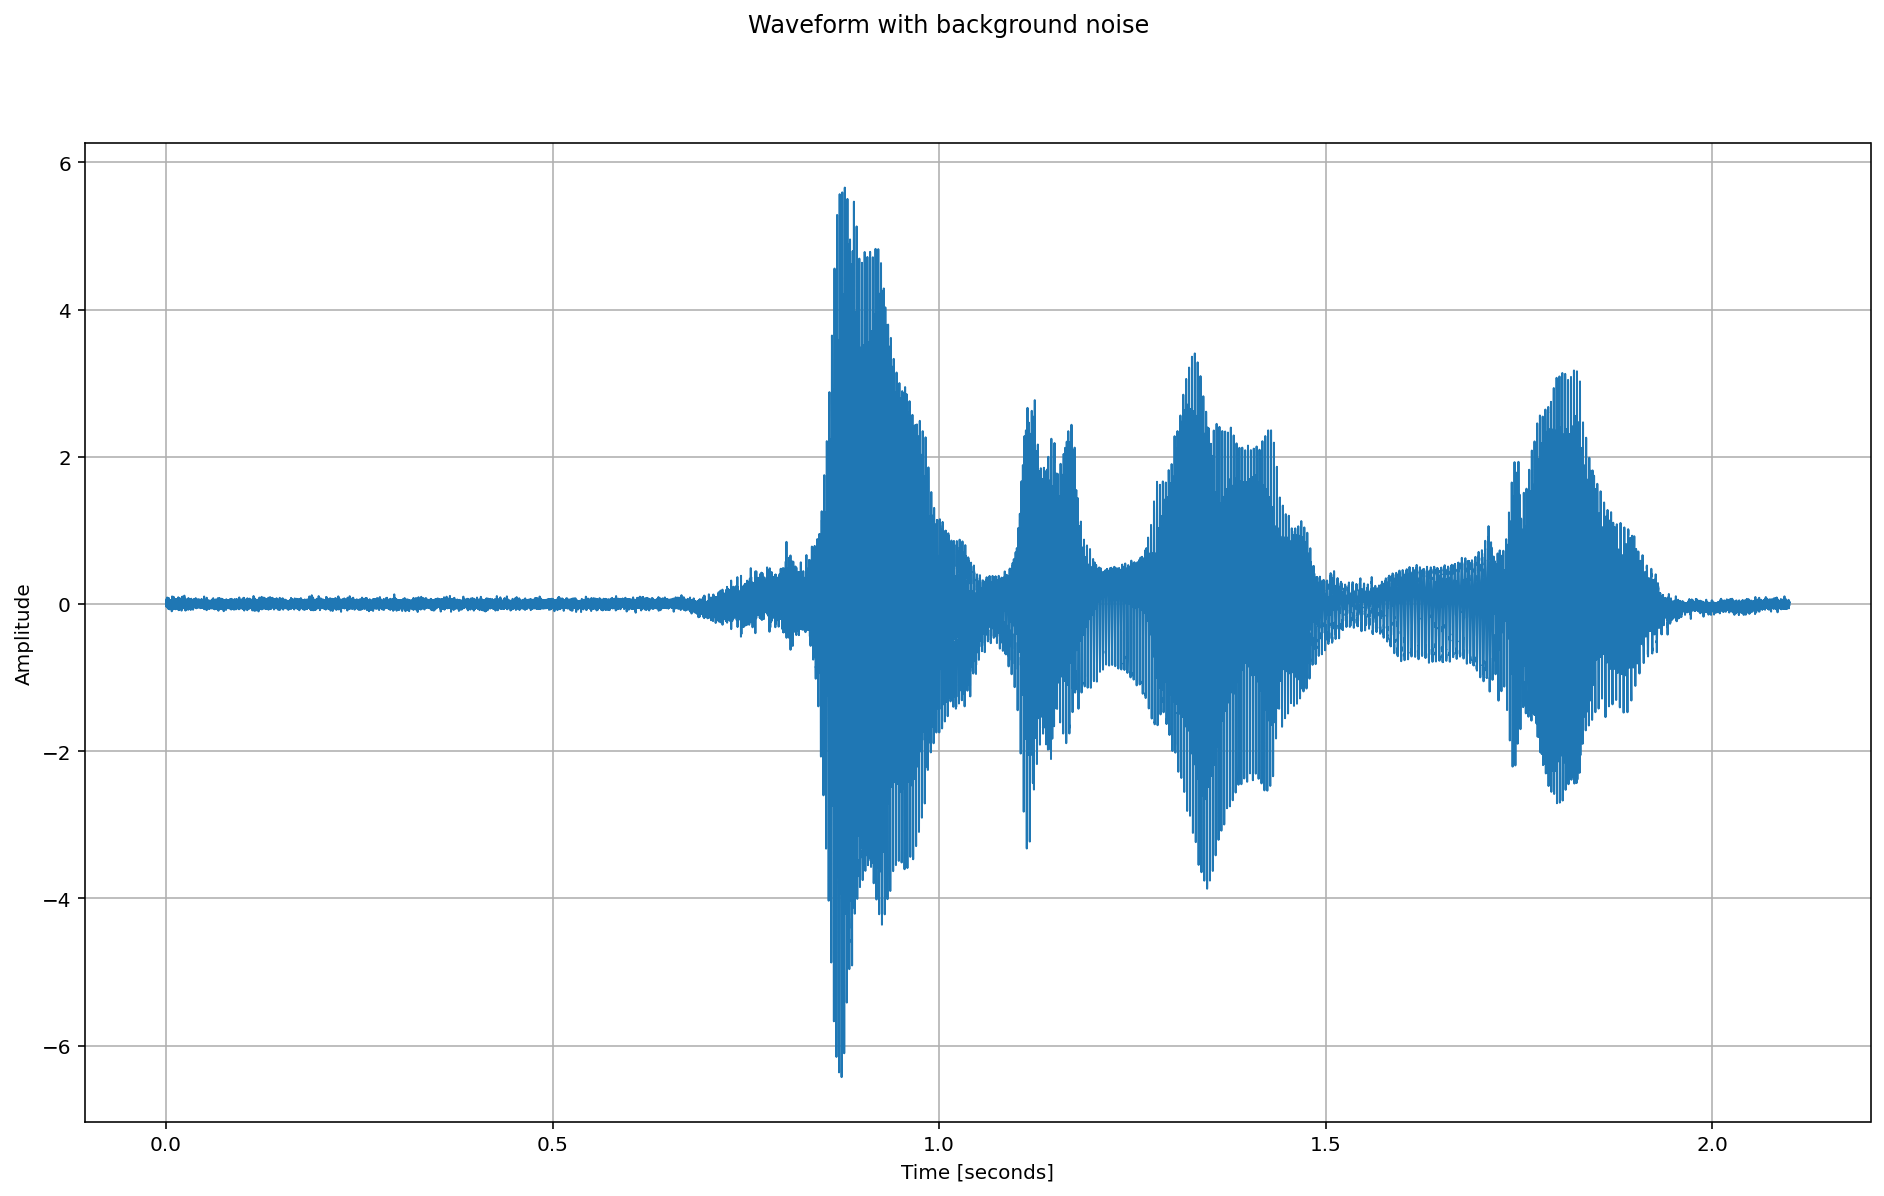

In [ ]:
noisy_waveform = noise(waveform)
plot_waveform(noisy_waveform, sample_rate, title="Waveform with background noise")
ipd.Audio(noisy_waveform, rate=sample_rate)

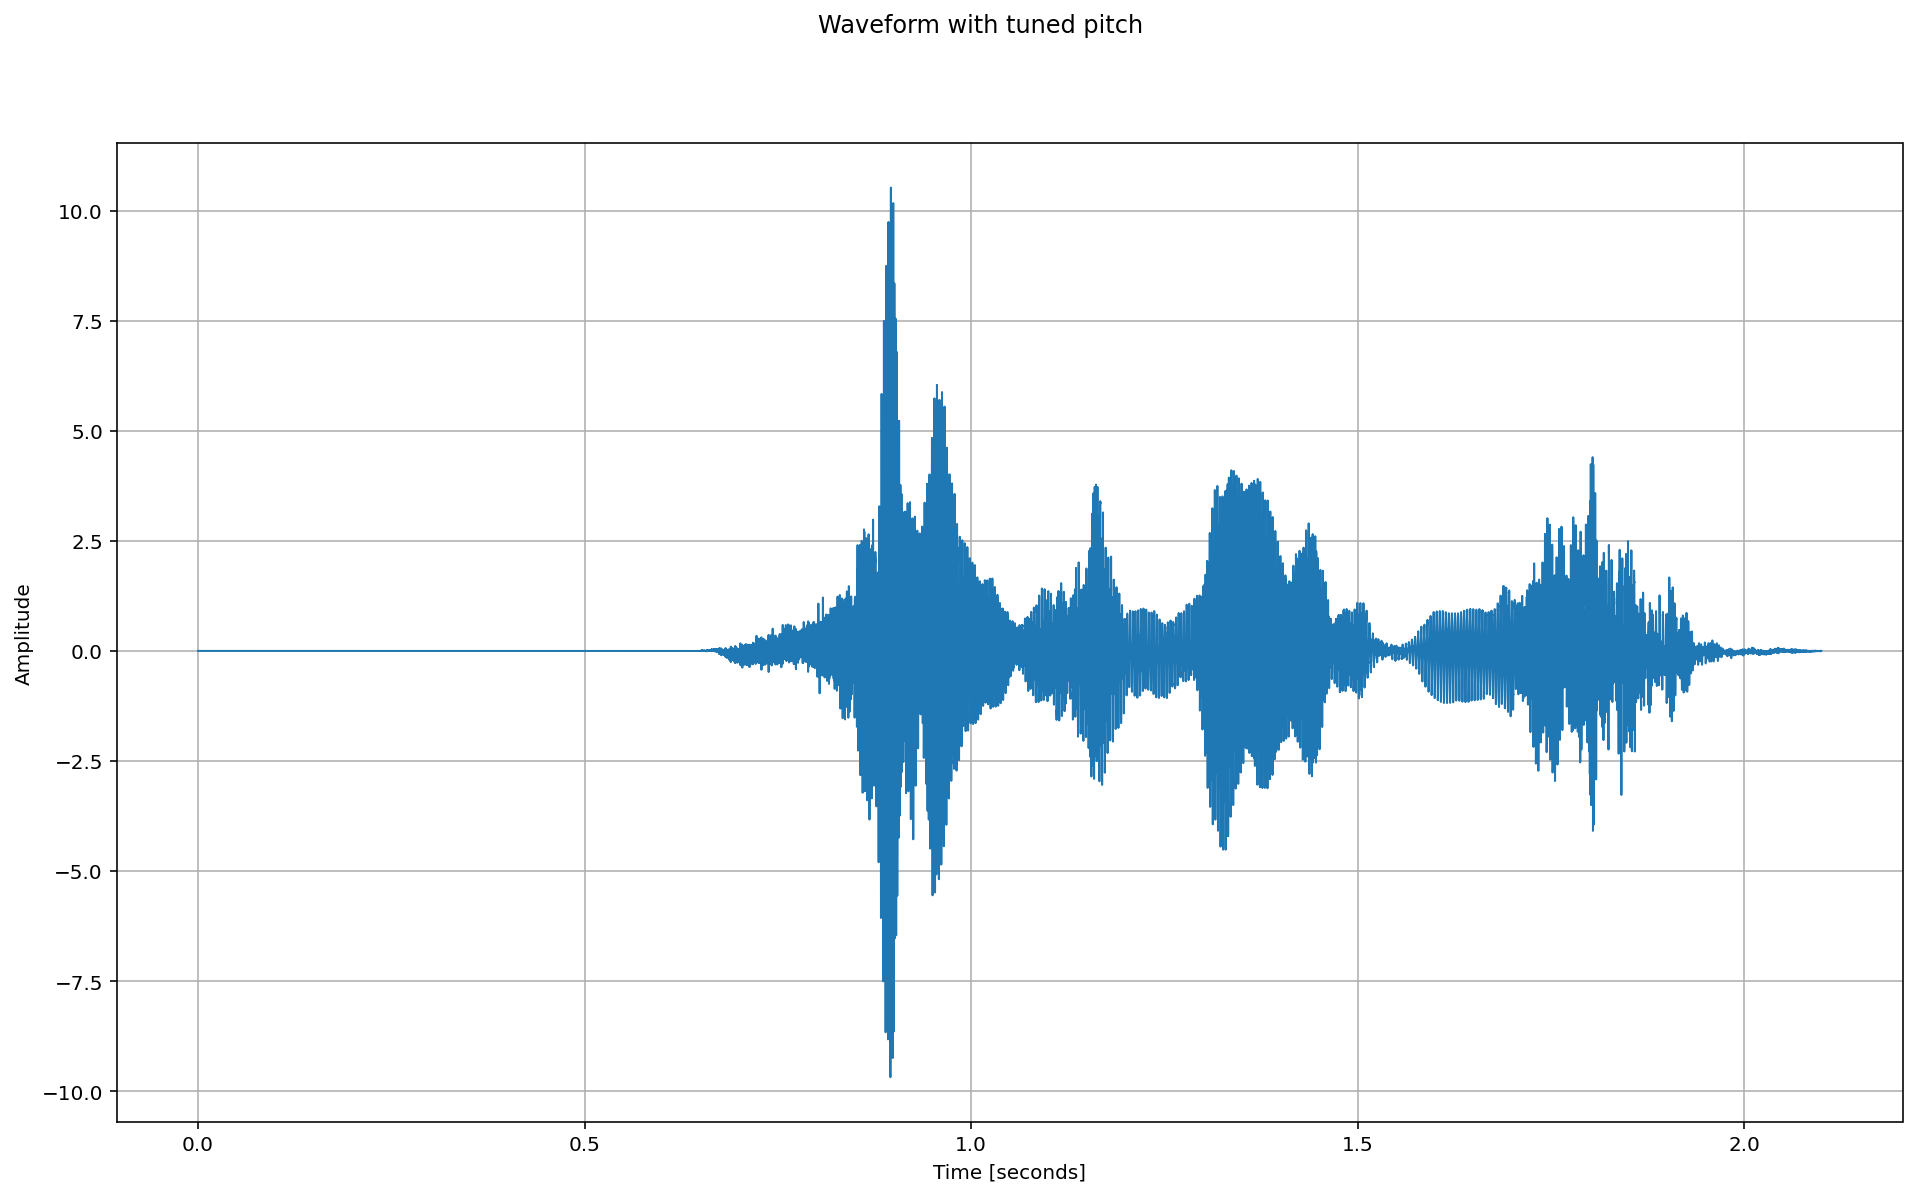

In [ ]:
pitch_waveform = pitch(waveform, sample_rate)
plot_waveform(pitch_waveform, sample_rate, title="Waveform with tuned pitch")
ipd.Audio(pitch_waveform, rate=sample_rate)

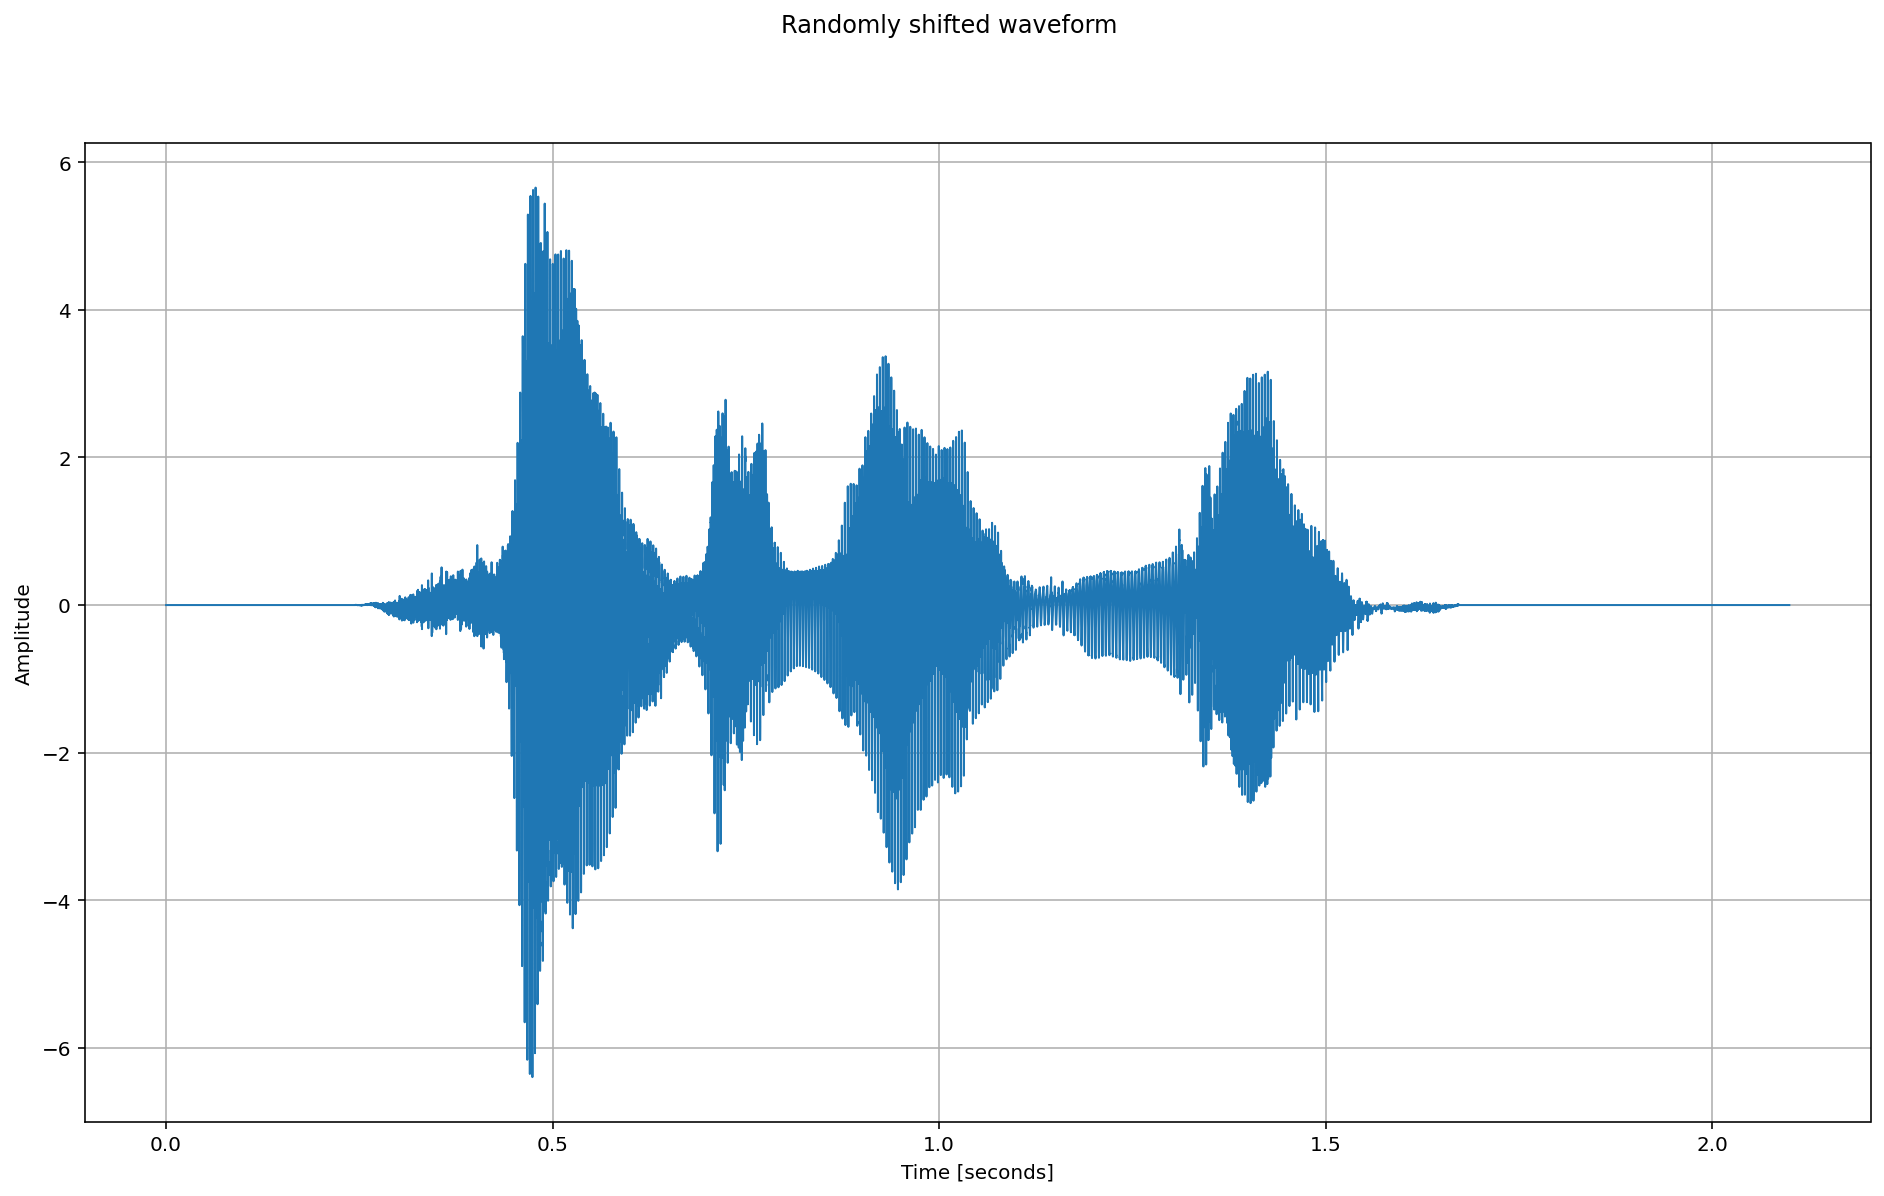

In [ ]:
randomly_shifted_waveform = random_shift(waveform)
plot_waveform(randomly_shifted_waveform, sample_rate, title="Randomly shifted waveform")
ipd.Audio(randomly_shifted_waveform, rate=sample_rate)

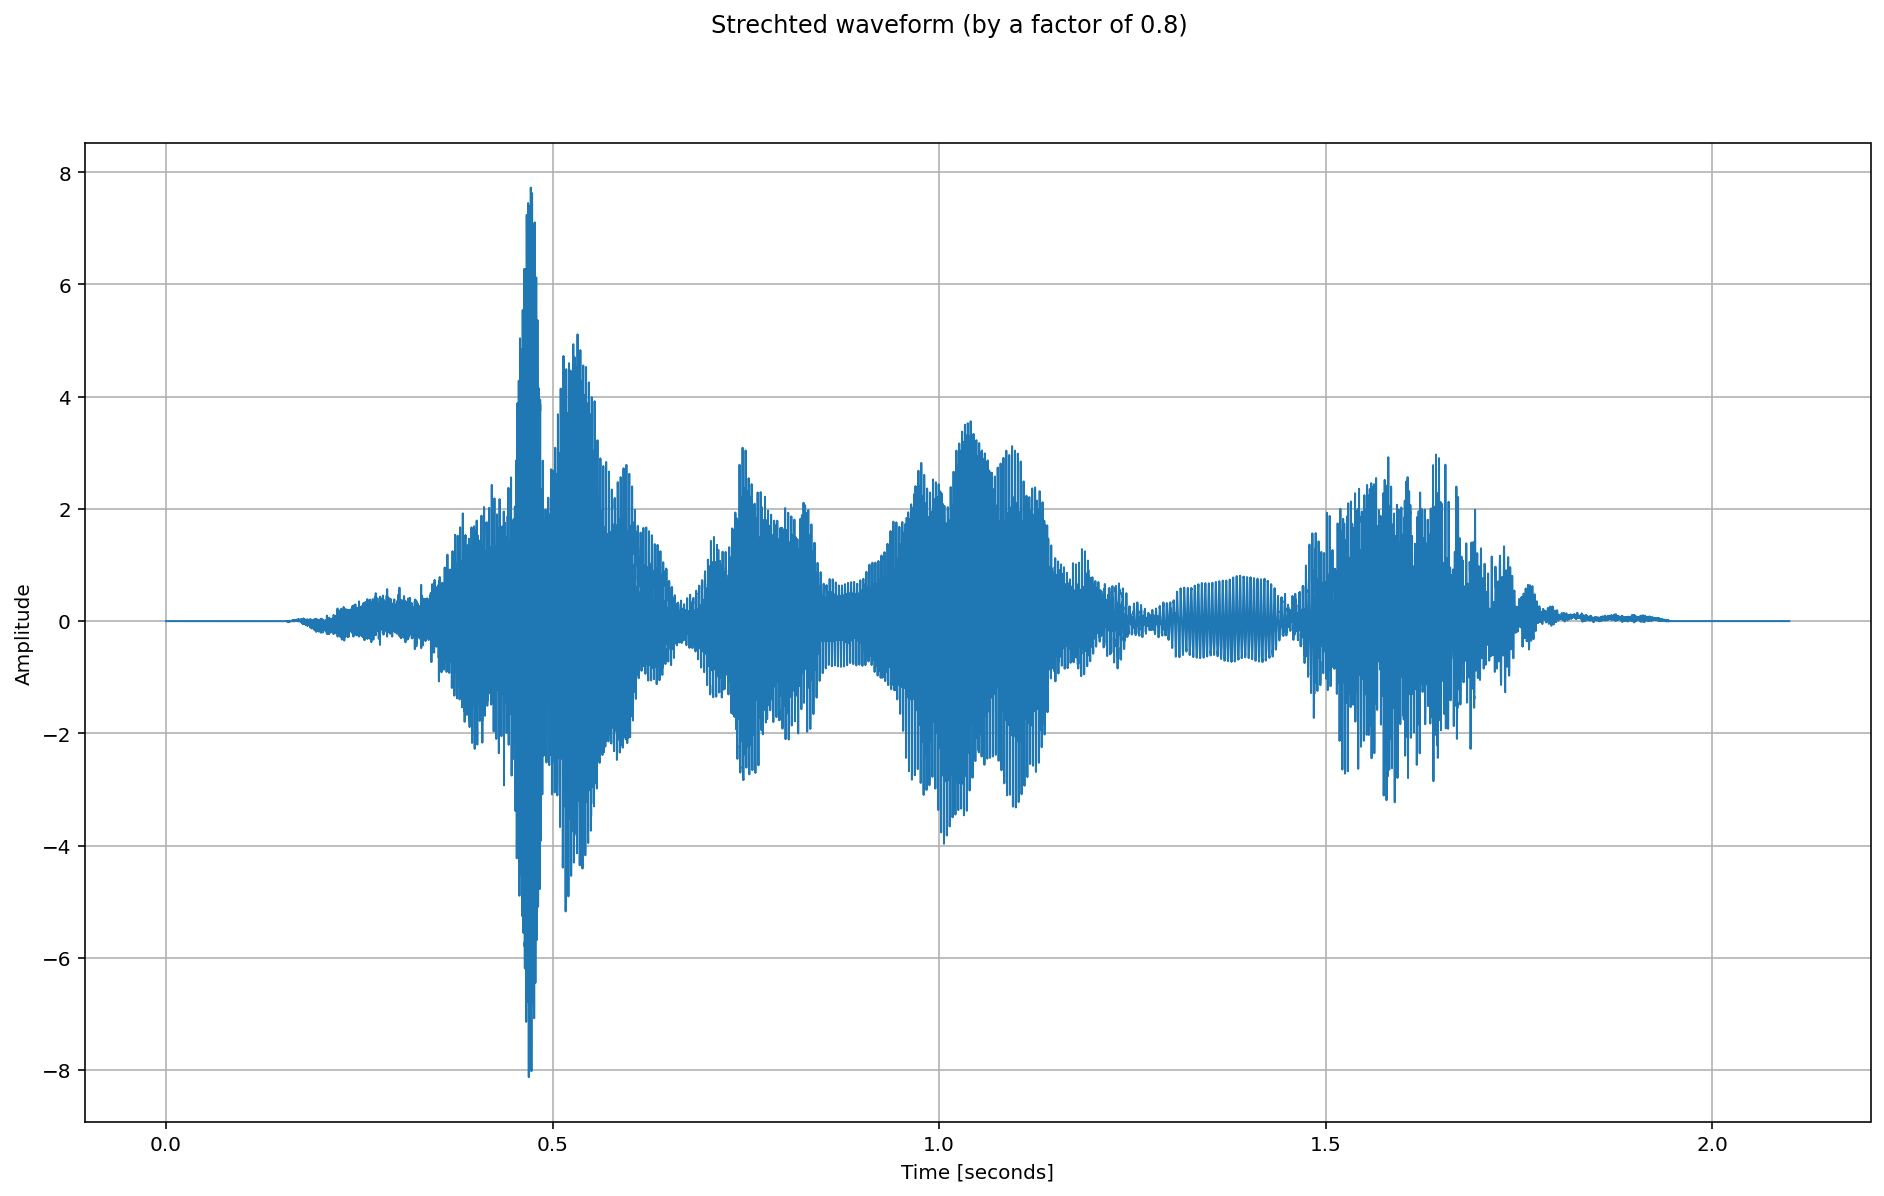

In [ ]:
slow_waveform = stretch(waveform, rate=0.8)
plot_waveform(slow_waveform, sample_rate, title="Strechted waveform (by a factor of 0.8)")
ipd.Audio(slow_waveform, rate=sample_rate)

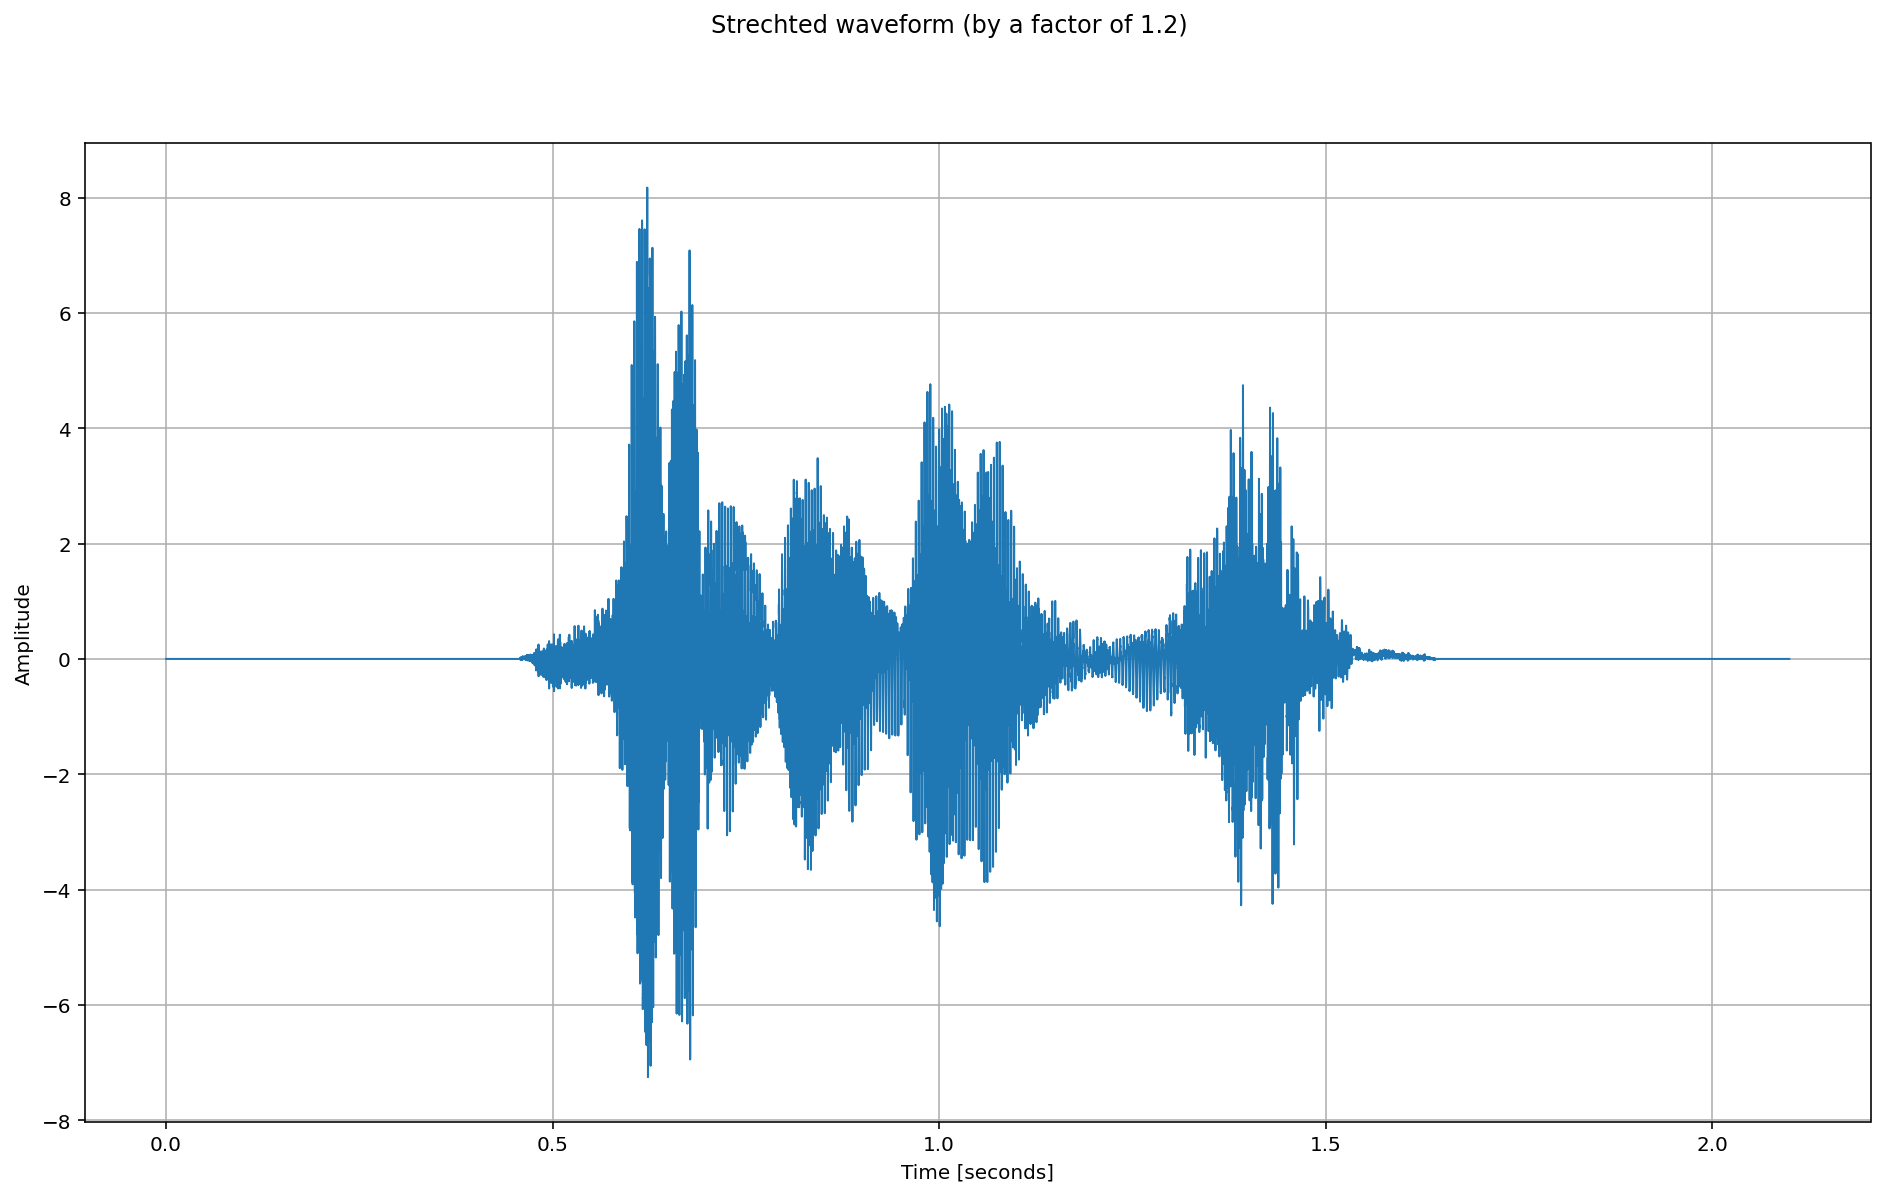

In [ ]:
fast_waveform = stretch(waveform, rate=1.2)
plot_waveform(fast_waveform, sample_rate, title="Strechted waveform (by a factor of 1.2)")
ipd.Audio(fast_waveform, rate=sample_rate)

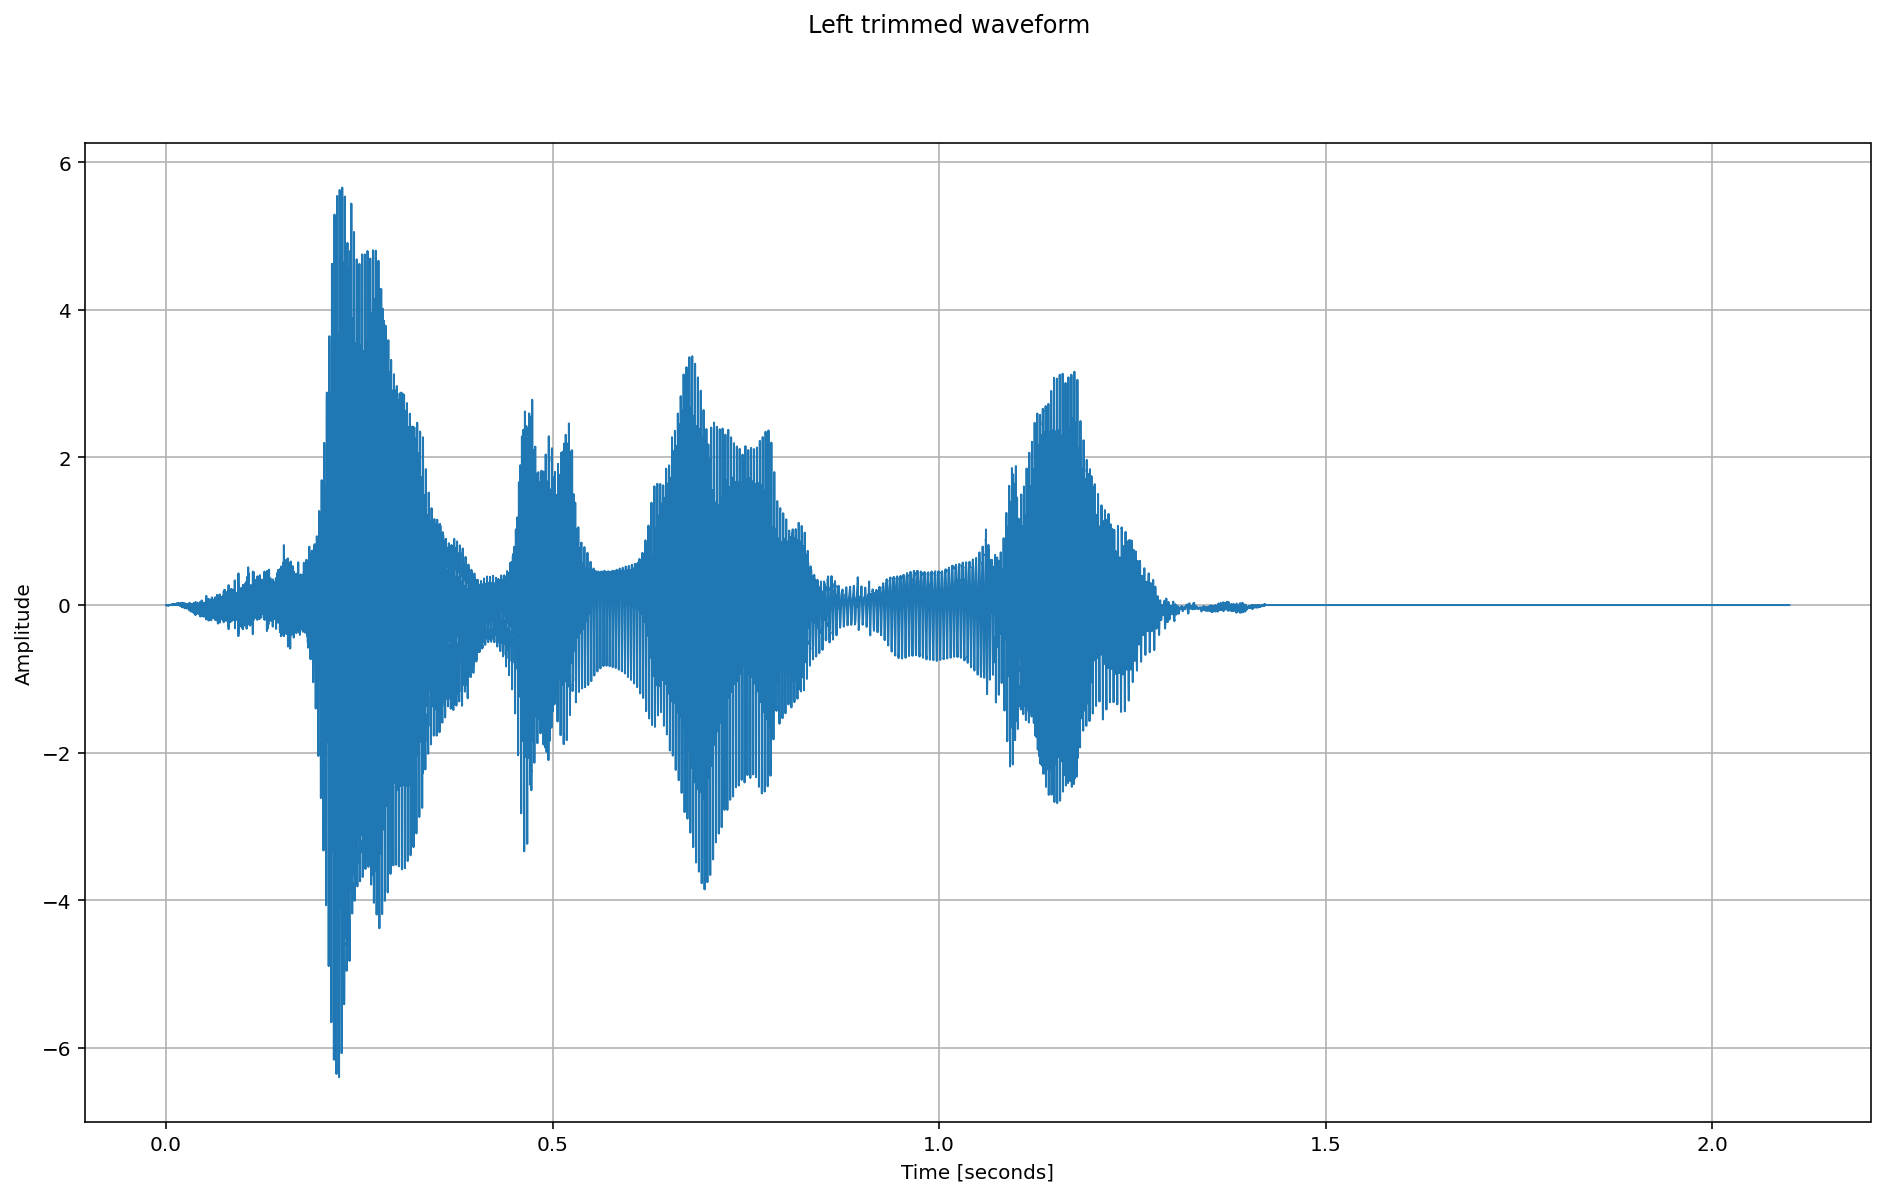

In [ ]:
left_trimmed_waveform = left_trim(waveform)
if(left_trimmed_waveform is not np.nan):
  plot_waveform(left_trimmed_waveform, sample_rate, title="Left trimmed waveform")
  ipd.Audio(left_trimmed_waveform, rate=sample_rate)

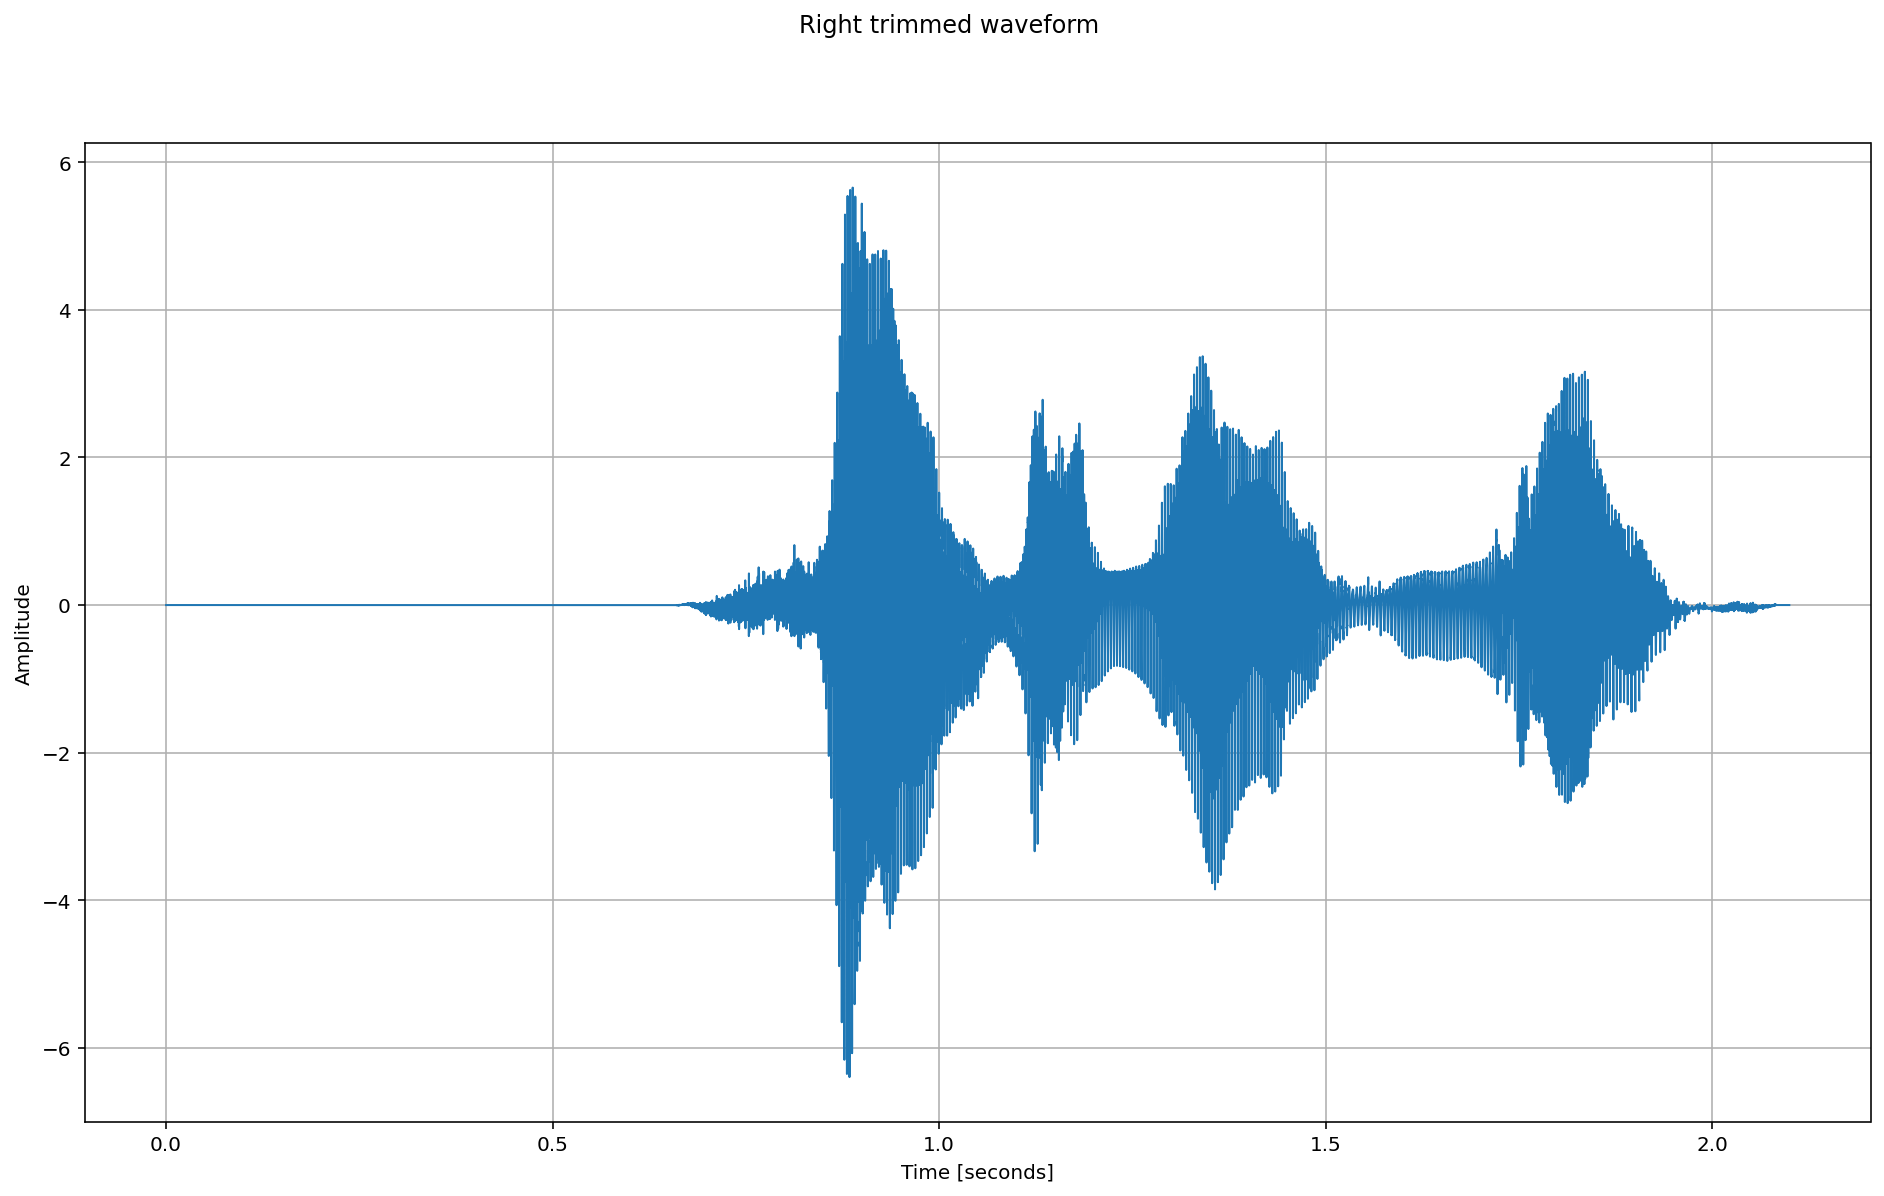

In [ ]:
right_trimmed_waveform = right_trim(waveform)
if(right_trimmed_waveform is not np.nan):
  plot_waveform(right_trimmed_waveform, sample_rate, title="Right trimmed waveform")
  ipd.Audio(right_trimmed_waveform, rate=sample_rate)

## Append augmentations to train set

In [ ]:
noisy_df = train_df.copy()
noisy_df["waveform"] = noisy_df["waveform"].progress_apply(noise)
noisy_df.to_pickle("/content/drive/MyDrive/CNN voice emotion recognition/noisy_df.pkl")

In [ ]:
pitch_df = train_df.copy()
pitch_df["waveform"] = pitch_df["waveform"].progress_apply(partial(pitch, sample_rate=22050))
pitch_df.to_pickle("/content/drive/MyDrive/CNN voice emotion recognition/pitch_df.pkl")

In [ ]:
randomly_shifted_df = train_df.copy()
randomly_shifted_df["waveform"] = randomly_shifted_df["waveform"].progress_apply(random_shift)
randomly_shifted_df.to_pickle("/content/drive/MyDrive/CNN voice emotion recognition/randomly_shifted_df.pkl")

In [ ]:
slow_df = train_df.copy()
slow_df["waveform"] = slow_df["waveform"].progress_apply(partial(stretch, rate=0.8))
slow_df.to_pickle("/content/drive/MyDrive/CNN voice emotion recognition/slow_df.pkl")

In [ ]:
fast_df = train_df.copy()
fast_df["waveform"] = fast_df["waveform"].progress_apply(partial(stretch, rate=1.2))
fast_df.to_pickle("/content/drive/MyDrive/CNN voice emotion recognition/fast_df.pkl")

In [ ]:
left_trimmed_df = train_df.copy()
left_trimmed_df["waveform"] = left_trimmed_df["waveform"].progress_apply(left_trim)
left_trimmed_df.dropna(axis=0, inplace=True)
left_trimmed_df.to_pickle("/content/drive/MyDrive/CNN voice emotion recognition/left_trimmed_df.pkl")

In [ ]:
right_trimmed_df = train_df.copy()
right_trimmed_df["waveform"] = right_trimmed_df["waveform"].progress_apply(right_trim)
right_trimmed_df.dropna(axis=0, inplace=True)
right_trimmed_df.to_pickle("/content/drive/MyDrive/CNN voice emotion recognition/right_trimmed_df.pkl")